In [1]:
import json
import torch
import numpy as np
import os
from torch.utils.data import Dataset, random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader 
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
from torch_geometric.utils import to_dense_batch
import torch.optim as optim
import json

sys.path.append(os.path.abspath(".."))

#### 1. Loading in the Data

In [2]:
from functions.data_loaders import get_graph_dataset

l2d_train_set = get_graph_dataset("../data/processed_graphical/l2d/", 
                                  mode="ego_veh", normalize=True, norm_method="zscore")
l2d_train_loader = DataLoader(l2d_train_set, batch_size=254, shuffle=True)

print(f"Total graphs: {len(l2d_train_set)}")  
for data in l2d_train_loader:
    print(data) 
    break

print('===========')

nup_train_set = get_graph_dataset("../data/processed_graphical/nuplan_final_final/", 
                                  mode="ego_veh", normalize=True, norm_method="zscore")
nup_train_loader = DataLoader(nup_train_set, batch_size=254, shuffle=True)

print(f"Total graphs: {len(nup_train_set)}")  
for data in nup_train_loader:
    print(data) 
    break

Total graphs: 9593
HeteroDataBatch(
  ego={
    x=[1981, 6],
    batch=[1981],
    ptr=[255],
  },
  vehicle={
    x=[5915, 6],
    batch=[5915],
    ptr=[243],
  },
  window_meta={ episode_path=[254] },
  (ego, to, ego)={ edge_index=[2, 1727] },
  (ego, to, vehicle)={ edge_index=[2, 5915] }
)
Total graphs: 18977


/Users/mariantemprana/Documents/GitHub/Traffic_Semantic_Graphs/functions/data_loaders.py:26: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std = x.std(dim=0, keepdim=True).clamp_min(1e-6)


HeteroDataBatch(
  ego={
    x=[942, 6],
    batch=[942],
    ptr=[255],
  },
  vehicle={
    x=[13404, 6],
    batch=[13404],
    ptr=[255],
  },
  window_meta={ episode_path=[254] },
  (ego, to, ego)={ edge_index=[2, 688] },
  (ego, to, vehicle)={ edge_index=[2, 13404] }
)


#### 2. Quantizing the Features

In [3]:
from functions.autoencoder import QuantileFeatureQuantizer

quantizer = QuantileFeatureQuantizer(bins=32, node_types=("ego", "vehicle"))
quantizer.fit(l2d_train_loader)
quantizer.fit(nup_train_loader)

#### 3. Setting up and Initializing Models (No Masking)

In [4]:
from functions.autoencoder import compute_feature_entropy_over_loader

node_types = ["ego", "vehicle"]
edge_types = [
    ("ego", "to", "ego"),
    ("ego", "to", "vehicle"),
]
metadata = (node_types, edge_types)
feature_entropy_l2d = compute_feature_entropy_over_loader(l2d_train_loader,metadata[0],quantizer)
feature_entropy_nup = compute_feature_entropy_over_loader(nup_train_loader,metadata[0],quantizer)

/Users/mariantemprana/Documents/GitHub/Traffic_Semantic_Graphs/functions/autoencoder.py:132: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BucketizationUtils.h:34.)
  xi = torch.bucketize(x[:, f], boundaries=edges[f], right=False)


In [5]:
from functions.autoencoder import HeteroGraphAutoencoder, ProjectionHead
from torch_geometric.nn import GATConv, GraphConv, SAGEConv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
spec = quantizer.spec() 

hidden_dim, feat_emb_dim, node_embed_dim, proj_graph_emb_dim = 128, 32, 128, 552
conv_layer_autoencoder = SAGEConv
graph_embed_dim = node_embed_dim * len(metadata[0])

model_l2d = HeteroGraphAutoencoder(metadata,
                                   hidden_dim=hidden_dim,
                                   embed_dim=node_embed_dim,
                                   quantizer_spec=spec,
                                   feat_emb_dim=feat_emb_dim,
                                   use_feature_mask=True,
                                   feature_entropy=feature_entropy_l2d,
                                   trainable_gates=False,
                                   conv_layer_cls=conv_layer_autoencoder).to(device)
model_nup = HeteroGraphAutoencoder(metadata,
                                   hidden_dim=hidden_dim,
                                   embed_dim=node_embed_dim,
                                   quantizer_spec=spec,
                                   feat_emb_dim=feat_emb_dim,
                                   use_feature_mask=True,
                                   feature_entropy=feature_entropy_nup,
                                   trainable_gates=False,
                                   conv_layer_cls=conv_layer_autoencoder).to(device)
proj_head = ProjectionHead(in_dim=graph_embed_dim, proj_dim=proj_graph_emb_dim).to(device)

lambda_kl = 0.1
opt = torch.optim.Adam([
    {'params': model_l2d.parameters(), 'lr': 1e-3},
    {'params': model_nup.parameters(), 'lr': 1e-3},
    {'params': proj_head.parameters(), 'lr': 1e-4}
])

#### 4. Training Models (No Masking)

In [ ]:
from functions.autoencoder import feature_loss, edge_loss, kl_divergence_between_gaussians, batched_graph_embeddings

num_epochs = 40
for epoch in range(num_epochs):
    model_l2d.train()
    model_nup.train()
    proj_head.train()

    running_loss = 0.0
    running_kl = 0.0

    # zip assumes both loaders have similar length
    for batch_l2d, batch_nup in zip(l2d_train_loader, nup_train_loader):

        # -------------
        # L2D forward
        # -------------
        batch_l2d = batch_l2d.to(device)
        batch_l2d = quantizer.transform_inplace(batch_l2d)

        z_l2d_dict, feat_logits_l2d, edge_logits_l2d = model_l2d(batch_l2d)
        lf_l2d = feature_loss(feat_logits_l2d, batch_l2d)
        le_l2d = edge_loss(edge_logits_l2d, z_l2d_dict, model_l2d.edge_decoders)
        z_l2d = batched_graph_embeddings(z_l2d_dict, batch_l2d, metadata,embed_dim_per_type=node_embed_dim)

        # -------------
        # nuPlan forward
        # -------------
        batch_nup = batch_nup.to(device)
        batch_nup = quantizer.transform_inplace(batch_nup)

        z_nup_dict, feat_logits_nup, edge_logits_nup = model_nup(batch_nup)
        lf_nup = feature_loss(feat_logits_nup, batch_nup)
        le_nup = edge_loss(edge_logits_nup, z_nup_dict, model_nup.edge_decoders)
        z_nup = batched_graph_embeddings(z_nup_dict, batch_nup, metadata,embed_dim_per_type=node_embed_dim)

        # -------------
        # Projection & KL alignment
        # -------------
        z_l2d_proj = F.normalize(proj_head(z_l2d), dim=-1)
        z_nup_proj = F.normalize(proj_head(z_nup), dim=-1)

        kl_1 = kl_divergence_between_gaussians(z_l2d_proj, z_nup_proj)
        kl_2 = kl_divergence_between_gaussians(z_nup_proj, z_l2d_proj)
        kl_loss = kl_1 + kl_2

        # -------------
        # Total loss
        # -------------
        total_loss = (
            lf_l2d + le_l2d +
            lf_nup + le_nup +
            lambda_kl * kl_loss
        )

        opt.zero_grad()
        total_loss.backward()
        opt.step()

        running_loss += total_loss.item()
        running_kl += kl_loss.item()

    # ===========================
    # Logging
    # ===========================
    print(f"Epoch {epoch:03d} | "
          f"Total Loss: {running_loss:.4f} | "
          f"Features Loss L2D: {lf_l2d:.4f}, Nup: {lf_nup:.4f} | "
          f"Edges Loss L2D: {le_l2d:.4f}, Nup: {le_nup:.4f} | "
          f"KL Loss: {running_kl:.4f}")

Epoch 000 | Total Loss: 1414.6772 | Features Loss L2D: 2.8610, Nup: 3.2839 | Edges Loss L2D: 0.5906, Nup: 0.6513 | KL Loss: 11126.8475
Epoch 001 | Total Loss: 365.1150 | Features Loss L2D: 2.6138, Nup: 3.0917 | Edges Loss L2D: 0.5501, Nup: 0.5946 | KL Loss: 926.4612
Epoch 002 | Total Loss: 332.2190 | Features Loss L2D: 2.1969, Nup: 2.9200 | Edges Loss L2D: 0.4735, Nup: 0.5528 | KL Loss: 869.8873
Epoch 003 | Total Loss: 377.8396 | Features Loss L2D: 1.9210, Nup: 2.7653 | Edges Loss L2D: 0.4251, Nup: 0.5078 | KL Loss: 1574.4975
Epoch 004 | Total Loss: 298.2259 | Features Loss L2D: 1.7008, Nup: 2.5593 | Edges Loss L2D: 0.3682, Nup: 0.4645 | KL Loss: 959.9004
Epoch 005 | Total Loss: 254.7508 | Features Loss L2D: 1.4944, Nup: 2.4179 | Edges Loss L2D: 0.3359, Nup: 0.4109 | KL Loss: 727.9718


In [ ]:
from functions.visuals import visualize_graph_embeddings

fig, all_embeddings, all_sources = visualize_graph_embeddings(model_l2d,model_nup,proj_head,l2d_train_loader,
                                                              nup_train_loader,quantizer,metadata,node_embed_dim,
                                                              batched_graph_embeddings)

Suggested number of clusters (elbow method): 7


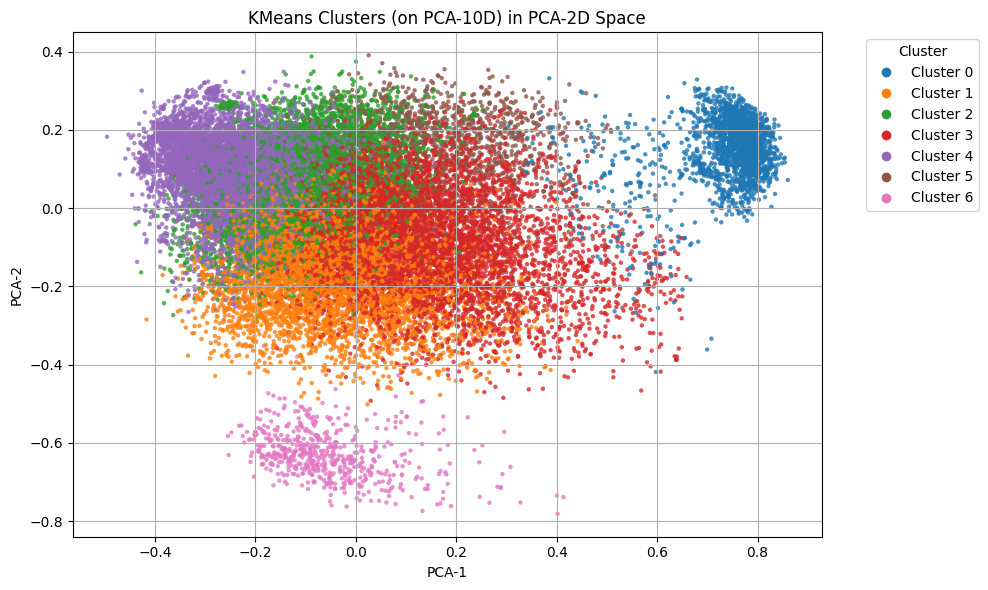

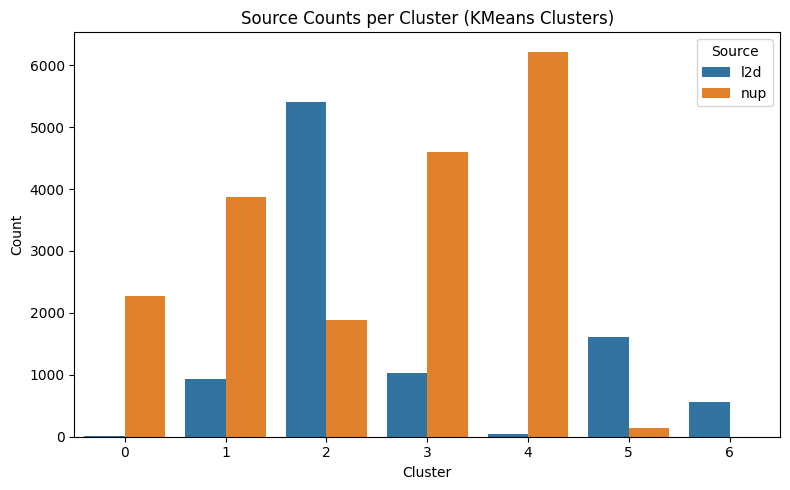

In [ ]:
from functions.visuals import find_optimal_kmeans_k, cluster_and_visualize_embeddings

best_k, _ = find_optimal_kmeans_k(all_embeddings)
cluster_labels,counts = cluster_and_visualize_embeddings(all_embeddings,all_sources)